# Language Modeling With a RNN - Assignment 8

This assignment involves working with language models developed with pretrained word vectors. We use sentences (sequences of words) to train language models for predicting movie review sentiment (thumbs up versus thumbs down). We study effects of word vector size, vocabulary size, and neural network structure (hyperparameters) on classification performance. We build on resources for recurrent neural networks (RNNs) as implemented in TensorFlow. RNNs are well suited to the analysis of sequences, as needed for natural language processing (NLP). Initial background reading for this assignment comes from Chapter 14 (pp. 379–411) of the Géron textbook:

Géron, A. (2017). Hands-on machine learning with Scikit-Learn & TensorFlow: Concepts, tools, and techniques to build intelligent systems. Sebastopol, CA: O’Reilly. [ISBN-13 978-1-491-96229-9]. Source code available via Github

#### Assignment Requirements
Install the Python chakin package, obtain GloVe (and perhaps non-GloVe) embeddings.
Load and run jump-start code for the assignment, which uses pretrained word vectors from GloVe.6B.50d, a vocabulary of 10,000 words, and movie review data.
Revise the jump-start code to accommodate two pretrained word vectors and two vocabulary sizes. These represent the cells of a completely crossed 2-by-2 experimental design, defining four distinct language models.
(Optional) Test two or more alternative RNN structures or hyperparameter settings.
Build and evaluate at least four language models of the experimental design. For each cell in the design, compute classification accuracy in the test set.

#### Evaluate the four language models and make recommendations to management.
Management Problem
Suppose management is thinking about using a language model to classify written customer reviews and call and complaint logs. If the most critical customer messages can be identified, then customer support personnel can be assigned to contact those customers.

How would you advise senior management? What kinds of systems and methods would be most relevant to the customer services function? Considering the results of this assignment in particular, what is needed to make an automated customer support system that is capable of identifying negative customer feelings? What can data scientists do to make language models more useful in a customer service function?

In [1]:
import numpy as np
import tensorflow as tf
import chakin

import json
import os
from collections import defaultdict

In [2]:
chakin.search(lang='English')

                   Name  Dimension                     Corpus VocabularySize  \
2          fastText(en)        300                  Wikipedia           2.5M   
11         GloVe.6B.50d         50  Wikipedia+Gigaword 5 (6B)           400K   
12        GloVe.6B.100d        100  Wikipedia+Gigaword 5 (6B)           400K   
13        GloVe.6B.200d        200  Wikipedia+Gigaword 5 (6B)           400K   
14        GloVe.6B.300d        300  Wikipedia+Gigaword 5 (6B)           400K   
15       GloVe.42B.300d        300          Common Crawl(42B)           1.9M   
16      GloVe.840B.300d        300         Common Crawl(840B)           2.2M   
17    GloVe.Twitter.25d         25               Twitter(27B)           1.2M   
18    GloVe.Twitter.50d         50               Twitter(27B)           1.2M   
19   GloVe.Twitter.100d        100               Twitter(27B)           1.2M   
20   GloVe.Twitter.200d        200               Twitter(27B)           1.2M   
21  word2vec.GoogleNews        300      

In [3]:
CHAKIN_INDEX = 16
NUMBER_OF_DIMENSIONS = 300
SUBFOLDER_NAME = "glove.840B.300D"

DATA_FOLDER = "embeddings"
ZIP_FILE = os.path.join(DATA_FOLDER, "{}.zip".format(SUBFOLDER_NAME))
ZIP_FILE_ALT = "glove" + ZIP_FILE[5:]  # sometimes it's lowercase only...
UNZIP_FOLDER = os.path.join(DATA_FOLDER, SUBFOLDER_NAME)
if SUBFOLDER_NAME[-1] == "d":
    GLOVE_FILENAME = os.path.join(UNZIP_FOLDER, "{}.txt".format(SUBFOLDER_NAME))
else:
    GLOVE_FILENAME = os.path.join(UNZIP_FOLDER, "{}.{}d.txt".format(SUBFOLDER_NAME, NUMBER_OF_DIMENSIONS))


if not os.path.exists(ZIP_FILE) and not os.path.exists(UNZIP_FOLDER):
    # GloVe by Stanford is licensed Apache 2.0: 
    #     https://github.com/stanfordnlp/GloVe/blob/master/LICENSE
    #     http://nlp.stanford.edu/data/glove.twitter.27B.zip
    #     Copyright 2014 The Board of Trustees of The Leland Stanford Junior University
    print("Downloading embeddings to '{}'".format(ZIP_FILE))
    chakin.download(number=CHAKIN_INDEX, save_dir='./{}'.format(DATA_FOLDER))
else:
    print("Embeddings already downloaded.")
    
if not os.path.exists(UNZIP_FOLDER):
    import zipfile
    if not os.path.exists(ZIP_FILE) and os.path.exists(ZIP_FILE_ALT):
        ZIP_FILE = ZIP_FILE_ALT
    with zipfile.ZipFile(ZIP_FILE,"r") as zip_ref:
        print("Extracting embeddings to '{}'".format(UNZIP_FOLDER))
        zip_ref.extractall(UNZIP_FOLDER)
else:
    print("Embeddings already extracted.")

Embeddings already downloaded.
Embeddings already extracted.


In [4]:
import pandas as pd
df = pd.read_csv('IMDB Dataset.csv') #https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df['review'].iloc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [6]:
# Lets encode labels: each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


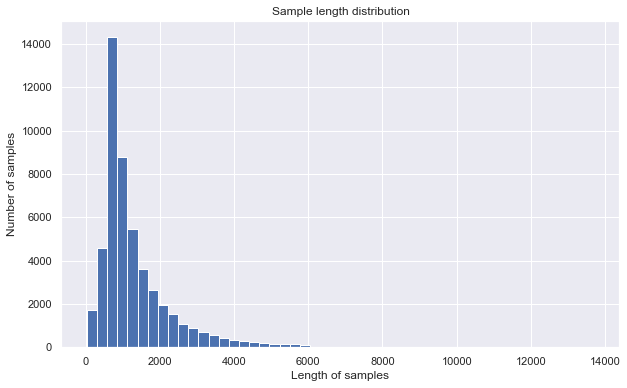

In [7]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize' : (12, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
import skimage
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(df['review'])], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import re

from sklearn.manifold import TSNE

### Text Normalizing function. Part of the following function was taken from this link. 
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    #text = re.sub(r",", " ", text)
    #text = re.sub(r"\.", " ", text)
    #text = re.sub(r"!", " ! ", text)
    #text = re.sub(r"\/", " ", text)
    #text = re.sub(r"\^", " ^ ", text)
    #text = re.sub(r"\+", " + ", text)
    #text = re.sub(r"\-", " - ", text)
    #text = re.sub(r"\=", " = ", text)
    #text = re.sub(r"'", " ", text)
    #text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    #text = re.sub(r":", " : ", text)
    #text = re.sub(r" e g ", " eg ", text)
    #text = re.sub(r" b g ", " bg ", text)
    #text = re.sub(r" u s ", " american ", text)
    #text = re.sub(r"\0s", "0", text)
    #text = re.sub(r" 9 11 ", "911", text)
    #text = re.sub(r"e - mail", "email", text)
    #text = re.sub(r"j k", "jk", text)
    #text = re.sub(r"\s{2,}", " ", text)
    ## Stemming
    #text = text.split()
    #stemmer = SnowballStemmer('english')
    #stemmed_words = [stemmer.stem(word) for word in text]
    #text = " ".join(stemmed_words)
    return text
# apply the above function to df['text']
df['review1'] = df['review'].map(lambda x: clean_text(x))
df.head()

Using TensorFlow backend.


,review,sentiment,review1
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching episode hooke...
1,A wonderful little production. <br /><br />The...,1,wonderful little production. <br / <br / the f...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically there family little boy jake thin...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei love time money visually stun...


## Model 1: Vocabulary Size of 20,000 and  GloVe.Twitter.50d

In [9]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['review1'])
sequences = tokenizer.texts_to_sequences(df['review1'])
data = pad_sequences(sequences, maxlen=300)

In [10]:
embeddings_index = dict()
f = open('embeddings/glove.twitter.27B/glove.twitter.27B.50d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [11]:
embedding_matrix = np.zeros((vocabulary_size, 50))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [12]:
labels = df[['sentiment']]

In [13]:
## create model
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 50, input_length=300, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
history = model_glove.fit(data, np.array(labels), validation_split=0.4, epochs = 5)

Train on 30000 samples, validate on 20000 samples
Epoch 1/5
30000/30000 [==============================] - 50s 2ms/step - loss: 0.4903 - accuracy: 0.7578 - val_loss: 0.4072 - val_accuracy: 0.8145
Epoch 2/5
30000/30000 [==============================] - 49s 2ms/step - loss: 0.3982 - accuracy: 0.8166 - val_loss: 0.3829 - val_accuracy: 0.8238
Epoch 3/5
30000/30000 [==============================] - 49s 2ms/step - loss: 0.3672 - accuracy: 0.8350 - val_loss: 0.3506 - val_accuracy: 0.8422
Epoch 4/5
30000/30000 [==============================] - 49s 2ms/step - loss: 0.3529 - accuracy: 0.8408 - val_loss: 0.3366 - val_accuracy: 0.8519
Epoch 5/5
30000/30000 [==============================] - 49s 2ms/step - loss: 0.3379 - accuracy: 0.8527 - val_loss: 0.3372 - val_accuracy: 0.8523


In [14]:
metrics = list(history.history.keys())
loss_values = history.history[metrics[2]]
val_loss_values = history.history[metrics[0]]
acc_values = history.history[metrics[3]]
val_acc_values = history.history[metrics[1]]
print("Final validation loss function is", val_loss_values[-1])
print("Final validation accuracy is", val_acc_values[-1])

Final validation loss function is 0.33719306008815764
Final validation accuracy is 0.8523499965667725


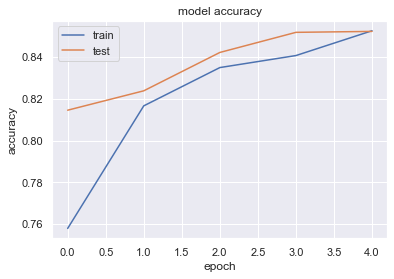

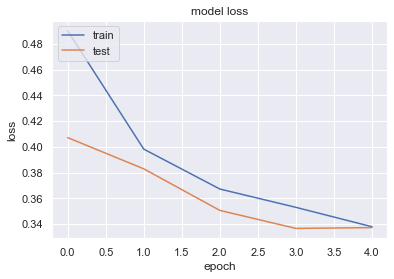

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
predictions = model_glove.predict(data, verbose=0)

In [17]:
df['prediction'] = predictions
df.head()

,review,sentiment,review1,prediction
0,One of the other reviewers has mentioned that ...,1,one reviewers mentioned watching episode hooke...,0.502502
1,A wonderful little production. <br /><br />The...,1,wonderful little production. <br / <br / the f...,0.978689
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...,0.912955
3,Basically there's a family where a little boy ...,0,basically there family little boy jake thin...,0.016336
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei love time money visually stun...,0.997659


## Model 2: Vocabulary Size of 40,000 and  GloVe.Twitter.50d

Train on 30000 samples, validate on 20000 samples
Epoch 1/5
30000/30000 [==============================] - 49s 2ms/step - loss: 0.4953 - accuracy: 0.7534 - val_loss: 0.4003 - val_accuracy: 0.8132
Epoch 2/5
30000/30000 [==============================] - 49s 2ms/step - loss: 0.4013 - accuracy: 0.8178 - val_loss: 0.3577 - val_accuracy: 0.8415
Epoch 3/5
30000/30000 [==============================] - 49s 2ms/step - loss: 0.3693 - accuracy: 0.8339 - val_loss: 0.3467 - val_accuracy: 0.8479
Epoch 4/5
30000/30000 [==============================] - 49s 2ms/step - loss: 0.3513 - accuracy: 0.8418 - val_loss: 0.3554 - val_accuracy: 0.8436
Epoch 5/5
30000/30000 [==============================] - 49s 2ms/step - loss: 0.3344 - accuracy: 0.8531 - val_loss: 0.3489 - val_accuracy: 0.8475
Final validation loss function is 0.34886709331274035
Final validation accuracy is 0.8475499749183655


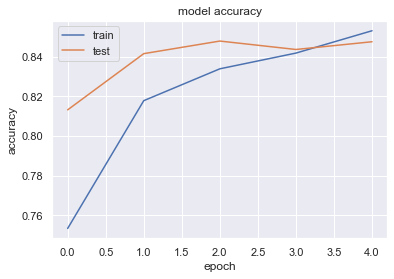

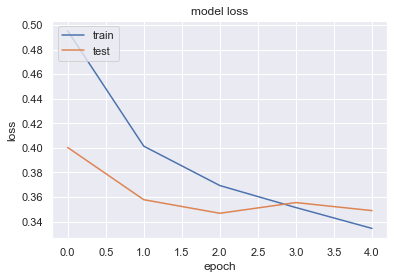

In [18]:
### Create sequence
vocabulary_size = 40000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['review1'])
sequences = tokenizer.texts_to_sequences(df['review1'])
data = pad_sequences(sequences, maxlen=300)

embeddings_index = dict()
f = open('embeddings/glove.twitter.27B/glove.twitter.27B.50d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocabulary_size, 50))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
            
labels = df[['sentiment']]

## create model
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 50, input_length=300, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
history = model_glove.fit(data, np.array(labels), validation_split=0.4, epochs = 5)

metrics = list(history.history.keys())
loss_values = history.history[metrics[2]]
val_loss_values = history.history[metrics[0]]
acc_values = history.history[metrics[3]]
val_acc_values = history.history[metrics[1]]
print("Final validation loss function is", val_loss_values[-1])
print("Final validation accuracy is", val_acc_values[-1])

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 3: Vocabulary Size of 20,000 and  GloVe.840B.300d

Train on 30000 samples, validate on 20000 samples
Epoch 1/5
30000/30000 [==============================] - 51s 2ms/step - loss: 0.3656 - accuracy: 0.8360 - val_loss: 0.3001 - val_accuracy: 0.8681
Epoch 2/5
30000/30000 [==============================] - 51s 2ms/step - loss: 0.2705 - accuracy: 0.8871 - val_loss: 0.3013 - val_accuracy: 0.8664
Epoch 3/5
30000/30000 [==============================] - 51s 2ms/step - loss: 0.2283 - accuracy: 0.9077 - val_loss: 0.2725 - val_accuracy: 0.8855
Epoch 4/5
30000/30000 [==============================] - 51s 2ms/step - loss: 0.1912 - accuracy: 0.9251 - val_loss: 0.2773 - val_accuracy: 0.8913
Epoch 5/5
30000/30000 [==============================] - 51s 2ms/step - loss: 0.1550 - accuracy: 0.9393 - val_loss: 0.3124 - val_accuracy: 0.8809
Final validation loss function is 0.3124365053653717
Final validation accuracy is 0.8809499740600586


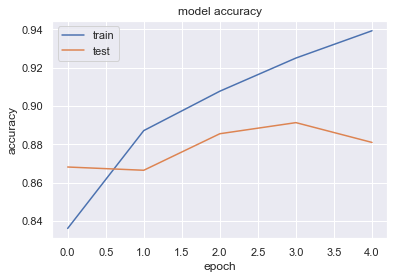

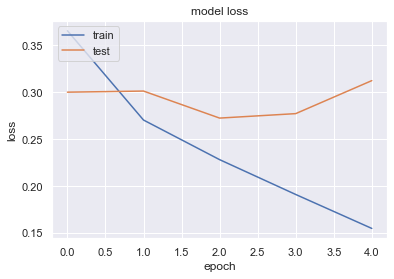

In [19]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['review1'])
sequences = tokenizer.texts_to_sequences(df['review1'])
data = pad_sequences(sequences, maxlen=300)

embeddings_index = dict()
f = open('embeddings/glove.840B.300D/glove.840B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None and len(embedding_vector)==300:
            embedding_matrix[index] = embedding_vector
            
labels = df[['sentiment']]

## create model
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 300, input_length=300, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
history = model_glove.fit(data, np.array(labels), validation_split=0.4, epochs = 5)

metrics = list(history.history.keys())
loss_values = history.history[metrics[2]]
val_loss_values = history.history[metrics[0]]
acc_values = history.history[metrics[3]]
val_acc_values = history.history[metrics[1]]
print("Final validation loss function is", val_loss_values[-1])
print("Final validation accuracy is", val_acc_values[-1])

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## Model 4: Vocabulary Size of 40,000 and  GloVe.840B.300d

Train on 30000 samples, validate on 20000 samples
Epoch 1/5
30000/30000 [==============================] - 70s 2ms/step - loss: 0.3624 - accuracy: 0.8388 - val_loss: 0.2960 - val_accuracy: 0.8758
Epoch 2/5
30000/30000 [==============================] - 70s 2ms/step - loss: 0.2718 - accuracy: 0.8874 - val_loss: 0.2737 - val_accuracy: 0.8821
Epoch 3/5
30000/30000 [==============================] - 70s 2ms/step - loss: 0.2304 - accuracy: 0.9061 - val_loss: 0.2725 - val_accuracy: 0.8863
Epoch 4/5
30000/30000 [==============================] - 70s 2ms/step - loss: 0.1941 - accuracy: 0.9231 - val_loss: 0.2986 - val_accuracy: 0.8853
Epoch 5/5
30000/30000 [==============================] - 70s 2ms/step - loss: 0.1606 - accuracy: 0.9372 - val_loss: 0.3101 - val_accuracy: 0.8799
Final validation loss function is 0.31013353430628776
Final validation accuracy is 0.8798999786376953


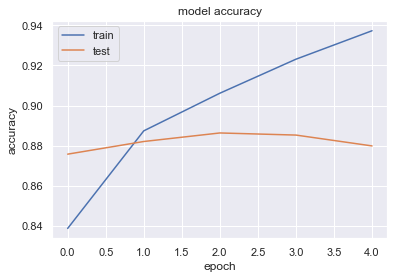

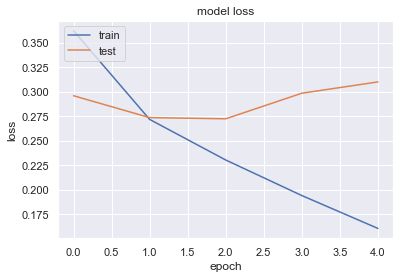

In [20]:
### Create sequence
vocabulary_size = 40000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['review1'])
sequences = tokenizer.texts_to_sequences(df['review1'])
data = pad_sequences(sequences, maxlen=300)

embeddings_index = dict()
f = open('embeddings/glove.840B.300D/glove.840B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None and len(embedding_vector)==300:
            embedding_matrix[index] = embedding_vector
            
labels = df[['sentiment']]

## create model
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 300, input_length=300, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
history = model_glove.fit(data, np.array(labels), validation_split=0.4, epochs = 5)

metrics = list(history.history.keys())
loss_values = history.history[metrics[2]]
val_loss_values = history.history[metrics[0]]
acc_values = history.history[metrics[3]]
val_acc_values = history.history[metrics[1]]
print("Final validation loss function is", val_loss_values[-1])
print("Final validation accuracy is", val_acc_values[-1])

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
